In [1]:
#importing all libraries
import numpy as np
from skimage import io, color, exposure, transform
#from sklearn.cross_validation import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

Using TensorFlow backend.


In [2]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img


def get_class(img_path):
    return int(img_path.split('/')[-2])

In [3]:
label_map = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

try:
    with  h5py.File('X.h5') as hf: 
        X, Y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X.h5")
    
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'GTSRB/Final_Training/Images/'
    imgs = []
    labels = []
    l_name = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)
            l_name.append(list(label_map.values())[label])

            if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]


    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Error in reading X.h5. Processing all images...
Processed 1000/39209
Processed 2000/39209
Processed 3000/39209
Processed 4000/39209
Processed 5000/39209
Processed 6000/39209
Processed 7000/39209
Processed 8000/39209
Processed 9000/39209
Processed 10000/39209
Processed 11000/39209
Processed 12000/39209
Processed 13000/39209
Processed 14000/39209
Processed 15000/39209
Processed 16000/39209
Processed 17000/39209
Processed 18000/39209
Processed 19000/39209
Processed 20000/39209
Processed 21000/39209
Processed 22000/39209
Processed 23000/39209
Processed 24000/39209
Processed 25000/39209
Processed 26000/39209
Processed 27000/39209
Processed 28000/39209
Processed 29000/39209
Processed 30000/39209
Processed 31000/39209
Processed 32000/39209
Processed 33000/39209
Processed 34000/39209
Processed 35000/39209
Processed 36000/39209
Processed 37000/39209
Processed 38000/39209
Processed 39000/39209


In [4]:
#helper function to display images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    plt.figure(figsize=(20, 20))
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=1.0, wspace=1.0)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].transpose(1,2,0))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "Image name: {0},\n True: {1}".format(l_name[i],cls_true[i])
        else:
            xlabel = "Image name: {0},\n True: {1}, \n Pred: {2}".format(l_name_test[i],cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

Populating the interactive namespace from numpy and matplotlib


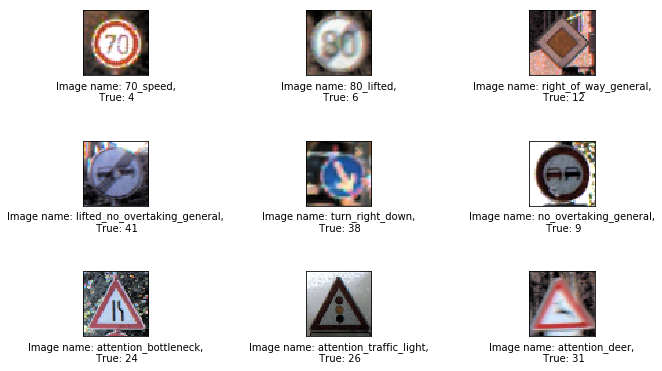

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
# Get the first nine images from the test-set.
images = X[0:9]

# Get the true classes for those first nine images.
cls_true = np.array([label.argmax() for label in Y[0:9]])

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [6]:
### Basic data summary.
# Number of training images
n_train = X.shape[0]

# Number of testing images
n_test = X.shape[0]

# the shape of an image
image_shape = X.shape[1:4]

#Number of classes in the dataset
n_classes = Y.shape[1]

print("Number of training images: ", n_train)
print("Number of testing images: ", n_test)
print("Shape of Image: ", image_shape)
print("Number of classes: ", n_classes)

Number of training images:  39209
Number of testing images:  39209
Shape of Image:  (3, 48, 48)
Number of classes:  43


In [7]:
X = X.reshape(X.shape[0], 48, 48, 3)

In [ ]:
X_train = X_train.astype('float32')
X_train /= 255

In [8]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

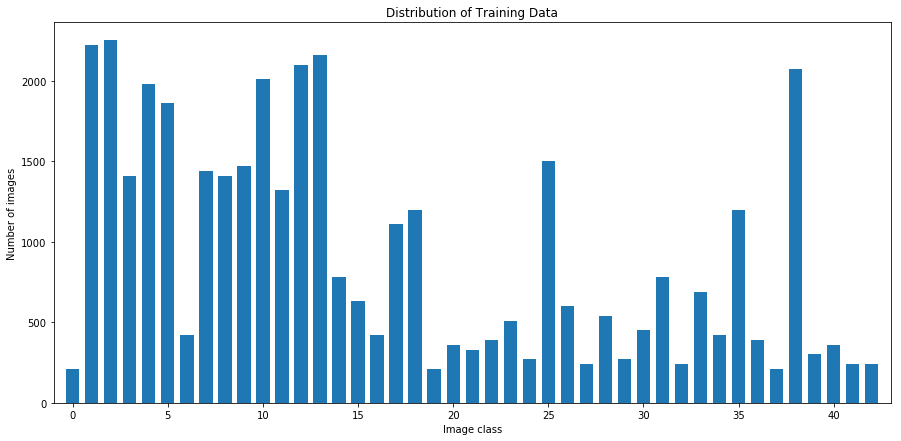

In [9]:
# Count frequency of each label
cls_true = np.array([label.argmax() for label in Y])
classes, counts = np.unique(cls_true, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 7]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(classes, counts, width=0.7, align='center')
plt.xlabel('Image class')
plt.ylabel('Number of images')
plt.title('Distribution of Training Data')
plt.show()

In [10]:
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))


# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [11]:
batch_size = 32
nb_epoch = 10

model.fit(X, Y,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.33,
          callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)]
            )

Train on 26270 samples, validate on 12939 samples
Epoch 1/10
26270/26270 [==============================] - 351s - loss: 3.3292 - acc: 0.0998 - val_loss: 2.5017 - val_acc: 0.2768

In [12]:
label_map = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}


#importing test images
import pandas as pd
test = pd.read_csv('GT-final_test.csv',sep=';')

X_test = []
y_test = []
l_name_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('GTSRB/Final_Test/Images/',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    l_name_test.append(list(label_map.values())[class_id])
    
X_test = np.array(X_test)
Y_test = np.array(y_test)

In [ ]:
X_test = X_test.astype('float32')
X_test /= 255

In [13]:
#printing y_test type
print(Y_test)

[16  1 38 ...,  6  7 10]


In [14]:
#converting y into one hot encode object
import keras
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [15]:
print(y_test)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


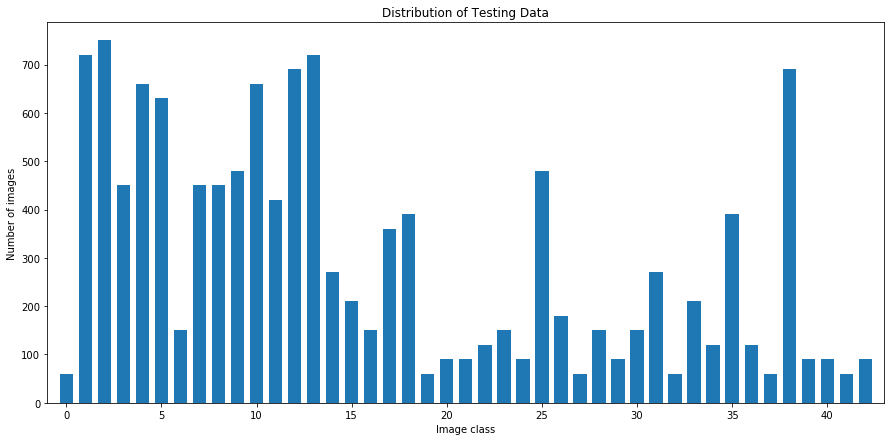

In [16]:
# Count frequency of each label
#cls_true = np.array([label.argmax() for label in y_test])
classes, counts = np.unique(Y_test, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 7]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(classes, counts, width=0.7, align='center')
plt.title('Distribution of Testing Data')
plt.xlabel('Image class')
plt.ylabel('Number of images')
plt.show()

In [17]:
X_test = X_test.reshape(X_test.shape[0], 48, 48, 3)
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', loss_and_metrics[0])
print('Test accuracy:', loss_and_metrics[1])

12630/12630 [==============================] - 43s     

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


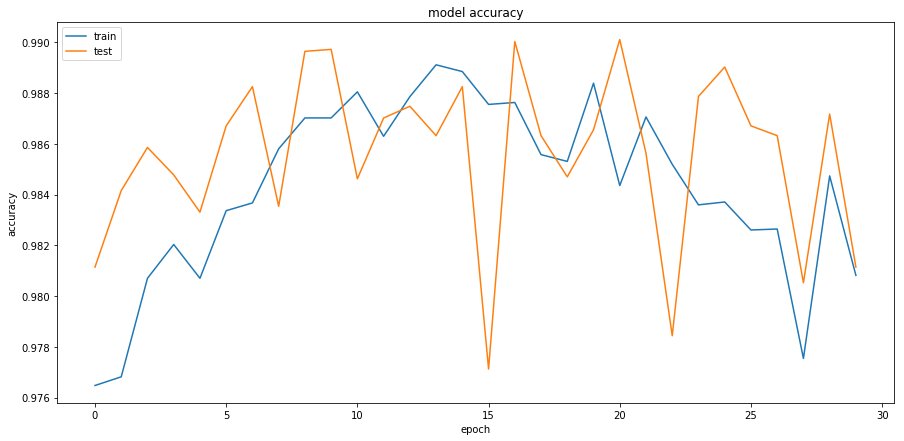

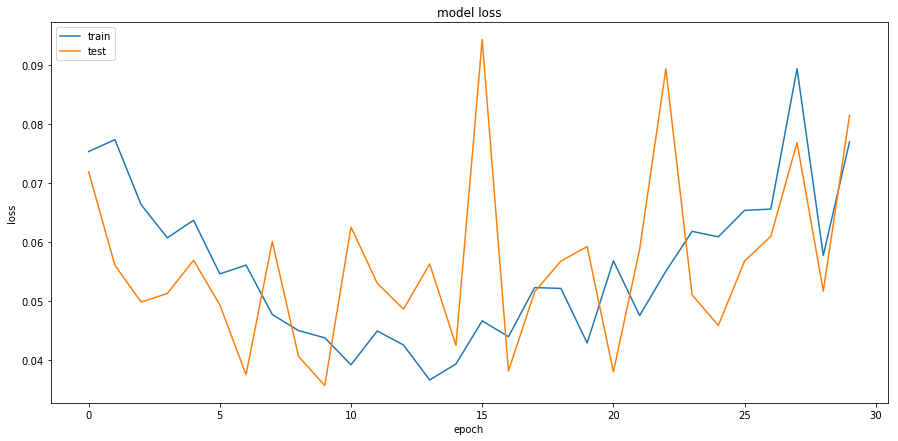

In [18]:
import matplotlib.pyplot as plt
history = model.fit(X, Y, validation_split=0.33, epochs=30, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
y_pred = model.predict_classes(X_test)

12630/12630 [==============================] - 42s     

In [20]:
y_pred

array([16,  1, 38, ...,  5,  7, 10])

In [22]:
Y_test

array([16,  1, 38, ...,  6,  7, 10])

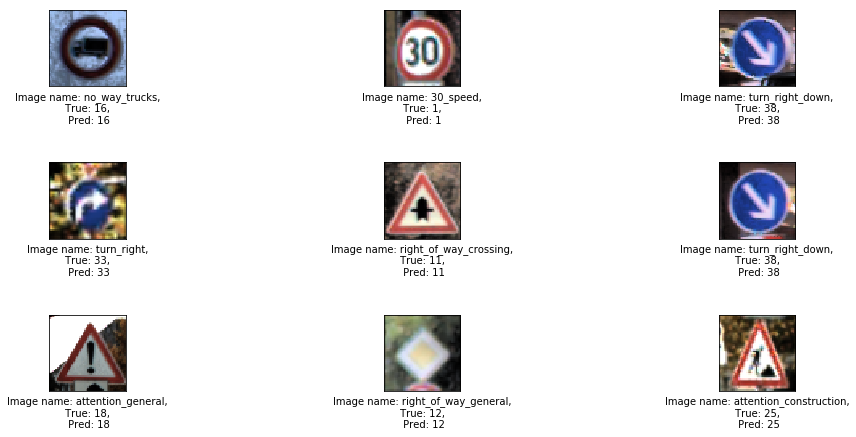

In [24]:
X_test = X_test.reshape(X_test.shape[0], 3,48, 48)

# Get the first nine images from the test-set.
images = X_test[0:9]

# Get the true classes for those first nine images.
cls_true = Y_test[0:9]

cls_pred = y_pred[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true,cls_pred=cls_pred)

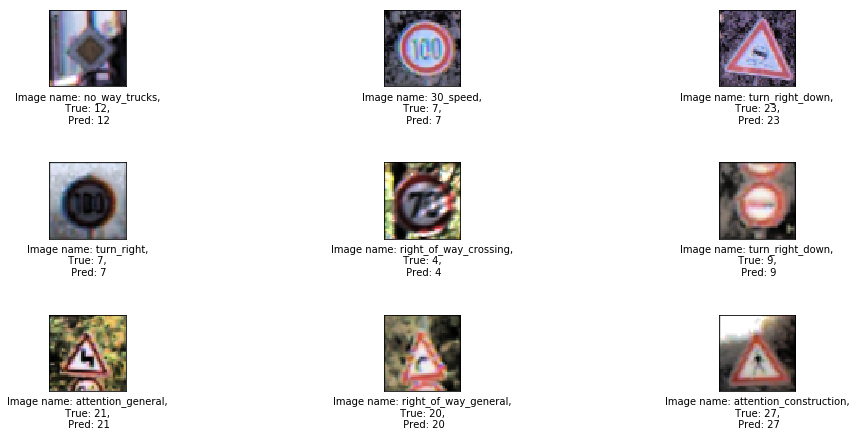

In [26]:
# Get the first nine images from the test-set.
images = X_test[10:19]

# Get the true classes for those first nine images.
cls_true = Y_test[10:19]

cls_pred = y_pred[10:19]


# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true,cls_pred=cls_pred)

In [28]:
true_table = pd.DataFrame({'col': Y_test==y_pred})

In [29]:
counts = true_table.groupby('col').size(); counts

col
False      934
True     11696
dtype: int64

In [30]:
true_table[true_table.col==False].index.tolist()[0:9]

[33, 48, 49, 50, 72, 114, 117, 119, 127]

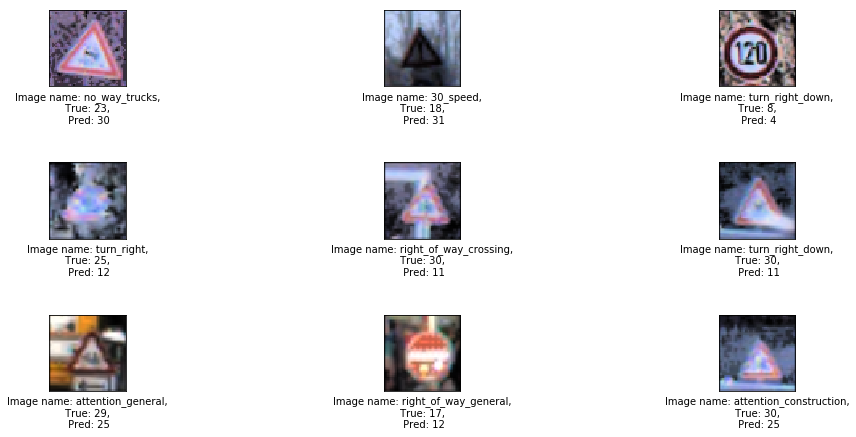

In [32]:
list_val = true_table[true_table.col==False].index.tolist()[0:9]
# Get the first nine images from the test-set.
images = X_test[list_val]

# Get the true classes for those first nine images.
cls_true = Y_test[list_val]

cls_pred = y_pred[list_val]


# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true,cls_pred=cls_pred)

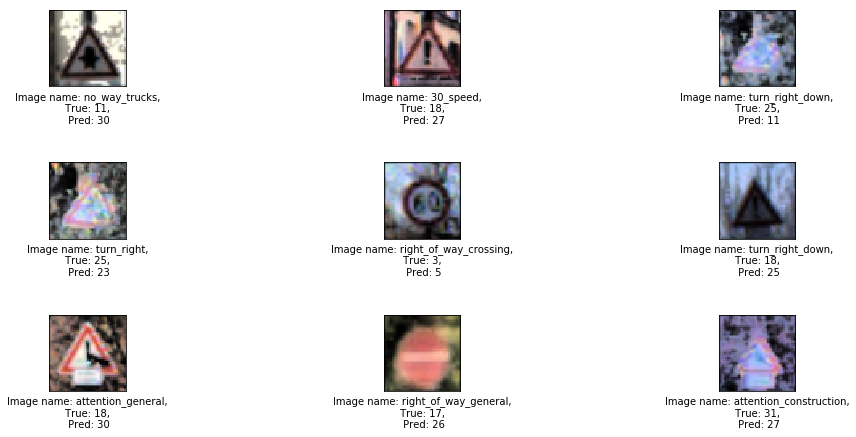

In [33]:
list_val = true_table[true_table.col==False].index.tolist()[10:19]
# Get the first nine images from the test-set.
images = X_test[list_val]

# Get the true classes for those first nine images.
cls_true = Y_test[list_val]

cls_pred = y_pred[list_val]


# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true,cls_pred=cls_pred)